##TASK IV Quantum Generative Adversarial Network (QGAN)
You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task. 

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [Download Input]. In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this 
task. The signal events are labeled with 1 while the background events are labeled with 0. 

Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC). 


###Implementation

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq

# for visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import sympy
import numpy as np

from matplotlib import style
  
plt.style.use('dark_background')

The given dataset for the task consists of 100 samples for training and 100 samples for testing (i.e 50:50). Stored in a numpy array file format and with 5 different features. The labels for each sample are binary, with a value of 0 representing background events and a value of 1 representing signal events.

In [ ]:
def load_dataset():
    """
    Loads and preprocesses the QIS_EXAM_200Events dataset.
    
    Returns:
    x_train (numpy.ndarray): Training set input data.
    y_train (numpy.ndarray): Training set labels.
    x_test (numpy.ndarray): Test set input data.
    y_test (numpy.ndarray): Test set labels.
    """
    # Load the dataset
    with np.load('QIS_EXAM_200Events.npz', allow_pickle=True) as data:
        training_input = data["training_input"].item()
        test_input = data["test_input"].item()

    # Concatenate the training and test input for each class
    training_input_0 = training_input['0']
    training_input_1 = training_input['1']
    test_input_0 = test_input['0']
    test_input_1 = test_input['1']
    x_train = np.concatenate((training_input_0, training_input_1), axis=0)
    x_test = np.concatenate((test_input_0, test_input_1), axis=0)

    # Create the labels for the training and test sets
    y_train = np.zeros((len(x_train),))
    y_train[len(training_input_0):] = 1
    y_test = np.zeros((len(x_test),))
    y_test[len(test_input_0):] = 1

    # Print the shapes of the datasets as a sanity check
    print("Training set shape: ", x_train.shape, y_train.shape)
    print("Test set shape: ", x_test.shape, y_test.shape)

    # Return the datasets and labels
    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()

(100, 5) (100,)
(100, 5) (100,)


In [ ]:
# Checking the minimum and maximum value of the features
print(x_train.min(), x_train.max())
print(x_test.min(), x_test.max())

-0.9999305803064449 0.9344843617214956
-0.9997083749335067 0.934061853011746


In [ ]:
def plot_histogram(x_train, x_test):
    """
    Plots a histogram of the feature values for the training and test sets.
    
    Args:
    x_train (numpy.ndarray): Training set input data.
    x_test (numpy.ndarray): Test set input data.
    """
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot a histogram of the feature values for the training set
    axs[0].hist(x_train.flatten(), bins=50)
    axs[0].set_title("Training Data")
    axs[0].set_xlabel("Feature Value")
    axs[0].set_ylabel("Frequency")

    # Plot a histogram of the feature values for the test set
    axs[1].hist(x_test.flatten(), bins=50)
    axs[1].set_title("Test Data")
    axs[1].set_xlabel("Feature Value")
    axs[1].set_ylabel("Frequency")

    # Display the plot
    plt.show()

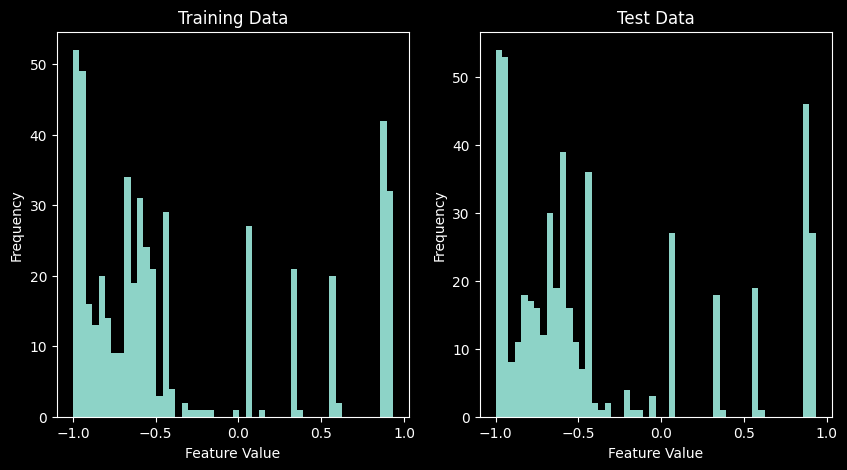

In [ ]:
# Plotting a histogram of the feature values
plot_histogram(x_train, x_test)

In [ ]:
def check_class_balances(y_train, y_test):
    """
    Checks the class balance for the training and test sets.
    
    Args:
    y_train (numpy.ndarray): Training set labels.
    y_test (numpy.ndarray): Test set labels.
    """
    # Count the number of instances of each class in the training set
    class_0_train = (y_train == 0).sum()
    class_1_train = (y_train == 1).sum()

    # Count the number of instances of each class in the test set
    class_0_test = (y_test == 0).sum()
    class_1_test = (y_test == 1).sum()

    # Print the results
    print("Training set - Class 0: {}, Class 1: {}".format(class_0_train, class_1_train))
    print("Test set - Class 0: {}, Class 1: {}".format(class_0_test, class_1_test))


In [ ]:
check_class_balances(y_train, y_test)

Class 0: 50 Class 1: 50
Class 0: 50 Class 1: 50


In [ ]:
def plot_class_balances(y_train, y_test):
    """
    Plots a bar chart of the class balances for the training and test sets.
    
    Args:
    y_train (numpy.ndarray): Training set labels.
    y_test (numpy.ndarray): Test set labels.
    """
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot a bar chart of the class balances for the training set
    axs[0].bar(['Class 0', 'Class 1'], [(y_train == 0).sum(), (y_train == 1).sum()])
    axs[0].set_title("Training Data")
    axs[0].set_ylabel("Number of Samples")

    # Plot a bar chart of the class balances for the test set
    axs[1].bar(['Class 0', 'Class 1'], [(y_test == 0).sum(), (y_test == 1).sum()])
    axs[1].set_title("Test Data")
    axs[1].set_ylabel("Number of Samples")

    # Display the plot
    plt.show()


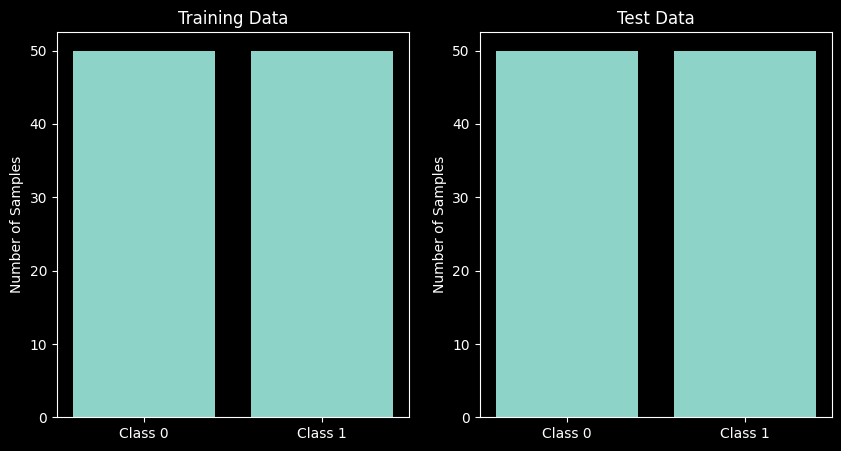

In [ ]:
plot_class_balances(y_train, y_test)

In [ ]:
def preprocess_labels(y_train, y_test):
    """
    Converts the label format from 0/1 to -1/1 and adds an extra column of ones to the label arrays.
    
    Args:
    y_train (numpy.ndarray): Training set labels.
    y_test (numpy.ndarray): Test set labels.
    
    Returns:
    Tuple of preprocessed label arrays (numpy.ndarray) for the training and test sets.
    """
    # Convert the label format from 0/1 to -1/1
    y_train = tf.keras.utils.to_categorical(y_train)*2-1
    y_test = tf.keras.utils.to_categorical(y_test)*2-1

    # Add an extra column of ones to the label arrays
    y_train = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
    y_test = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)

    # Print the shapes of the preprocessed label arrays
    print("Preprocessed label shapes:", y_train.shape, y_test.shape)

    # Return the preprocessed label arrays
    return y_train, y_test


In [ ]:
preprocess_labels(y_train, y_test)   

(100, 3) (100, 3)


###QGAN

Generative Adversarial Networks (GANs) are a type of deep learning model that have gained popularity for their ability to generate realistic and high-quality synthetic data. The basic idea behind GANs is to train two neural networks simultaneously: a generator and a discriminator. The generator is responsible for creating samples that resemble the training set's data, while the discriminator tries to differentiate between real and generated samples. This setup creates a feedback loop, where the generator tries to produce better samples to fool the discriminator, while the discriminator tries to become better at identifying fake samples.

While GANs have shown impressive results in many applications, they are limited by the computational power of classical computers. Quantum computing has emerged as a promising platform for machine learning, as it offers the potential for exponential speedup over classical computers for certain tasks. QGANs are a natural extension of GANs to the quantum computing domain.

QGANs implement the generator and discriminator functions using quantum circuits, which can create or categorize quantum states by leveraging quantum entanglement and superposition. In QGANs, the generator and discriminator are implemented as quantum circuits that take quantum states as input and output. The generator circuit takes a quantum state as input and applies a series of quantum gates to produce a new quantum state that represents a generated sample. The discriminator circuit takes a quantum state as input and applies a series of quantum gates to measure whether the input state is real or fake.

###Classical Data to Quantum Data: Angle Encoding

Classical data can be represented as a vector of real numbers, for example, a set of features x = (x1, x2, ..., xn) representing a sample. To convert this classical data into a quantum state, angle encoding can be used.

In angle encoding, each feature xi is treated as an angle θi for an RY gate that acts on a qubit. The RY gate can be defined as:

$$
RY(\theta) = \begin{pmatrix} \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\ \sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2}) \end{pmatrix}
$$

Thus, for a sample with $n$ features, we would require $n$ qubits with an RY gate on each qubit to encode the data. We can represent the quantum state for this sample as:

$$
|\psi\rangle = RY(\theta_1) \otimes RY(\theta_2) \otimes ... \otimes RY(\theta_n) |0\rangle^n
$$

where $|0\rangle^n$ represents the $n$-qubit zero state.

For example, if we have a sample with 5 features $(x_1, x_2, x_3, x_4, x_5)$, we would require 5 qubits and the quantum state would be:

$$
|\psi\rangle = RY(\theta_1) \otimes RY(\theta_2) \otimes RY(\theta_3) \otimes RY(\theta_4) \otimes RY(\theta_5) |0\rangle^5
$$

where $\theta_1, \theta_2, \theta_3, \theta_4, \theta_5$ are the angles corresponding to each feature.

Angle encoding can be used as a preprocessing step for various quantum machine learning algorithms, such as quantum support vector machines and quantum neural networks, to convert classical data into a quantum state that can be processed on a quantum computer.

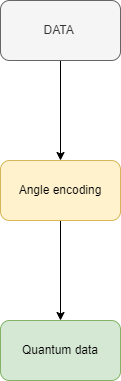

In [ ]:
def generate_data(X, qubits):
    """
    Generate quantum data from the dataset with angle encoding.

    Args:
    X (numpy.ndarray): The dataset to be encoded.
    qubits (list): The list of qubits to be used for the encoding.

    Returns:
    list: A list of Cirq circuits representing the quantum-encoded data.
    """

    quantum_data = []
    # iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()
        # iterate through sample's features
        for bit in range(len(sample)):
            circuit.append(cirq.ry(sample[bit])(qubits[bit]))
        
        quantum_data.append(circuit)

    return quantum_data

In [ ]:
def convert_to_quantum_data(data, qubits):
    """
    Converts classical data to quantum data using the given qubits.
    
    Args:
    data (numpy.ndarray): Input data to be converted.
    qubits (List[cirq.GridQubit]): List of qubits to be used for conversion.
    
    Returns:
    Quantum data (tf.Tensor) in the form of a tensor of circuit diagrams.
    """
    # Generate circuit diagrams for the input data using the given qubits
    circuit_diagrams = []
    for datum in data:
        circuit_diagram = generate_circuit(qubits, datum)
        circuit_diagrams.append(circuit_diagram)

    # Convert the circuit diagrams to a tensor of quantum data
    quantum_data = tfq.convert_to_tensor(circuit_diagrams)

    # Return the quantum data tensor
    return quantum_data

###Discriminating Signal Events from Background Events using Quantum Generative Adversarial Networks (QGANs) with Parametrized Quantum Circuits (PQCs)

The problem of discriminating signal events from background events is a fundamental challenge in many areas of physics, including particle physics and quantum computing. To address this challenge, we propose using a quantum generative adversarial network (QGAN), which consists of a generator and a discriminator.

The generator in our QGAN is a parametrized quantum circuit (PQC), which is designed to create synthetic data that resembles real data. The discriminator, on the other hand, is also a PQC, which is tasked with classifying the data into the correct label and determining whether the data is real or fake, in order to assess the quality of the generated data.

The architecture of our quantum discriminator is shown in Figures 1 and 2. There are 8 qubits in the discriminator, with the first five qubits being the data qubits and the final three qubits being the output qubits. Each data qubit is given a Hadamard gate, followed by a number of one-qubit unitaries and CNOT gates that entangle nearby qubits. For multiple layers, one can repeat the one-qubit unitaries and CNOT gates. At the end of the circuit, each output qubit receives a final one-qubit unitary gate. Pauli-Z gates are used to measure each output qubit.

The discriminator is trained on both quantum fake data and quantum real data. The quantum fake data is generated by the generator, while the quantum real data is obtained by encoding the real data through angle encoding. The discriminator is trained to output three values: the real/fake prediction [D] and the two class predictions [C0, C1]. The values of [C0, C1] correspond to the probabilities of the input data belonging to each class.

The discrimination task is formalized as follows: given an input quantum state $|\psi\rangle$, the discriminator output is a vector of three values $[D, C0, C1]$, where $D$ is the binary real/fake decision and $C0$ and $C1$ are the class probabilities. Mathematically, the output of the discriminator can be written as:

[D, C0, C1] = Discriminator(|ψ⟩)


In [ ]:
# Define the qubits to be used for the conversion
qubits = cirq.GridQubit.rect(1, 5)

# Convert the classical data to quantum data using the qubits
train_quantum_data = convert_to_quantum_data(x_train, qubits)
test_quantum_data = convert_to_quantum_data(x_test, qubits)

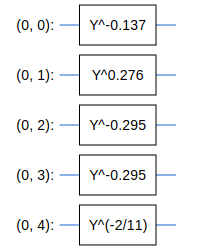

In [ ]:
SVGCircuit(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==1][0])

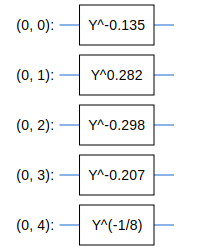

In [ ]:
SVGCircuit(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==-1][0])

We will create a Quantum generator function that requires three inputs: qubits, symbols, and layer. Qubits is a list of qubits that will be acted on by the circuit, symbols is a list of parameters that will be used to construct the circuit, and layer is an optional argument that determines the number of gate layers in the circuit, with a default value of 1.

In [ ]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    
    Args:
        bit (cirq.Qid): The qubit to apply the unitary to.
        symbols (list): A list of three float values representing the angles
            of rotation about the X, Y and Z axis respectively.
    
    Returns:
        cirq.Circuit: A Cirq circuit implementing the desired one-qubit unitary.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary.
    
    Args:
        bits (list): A list of two cirq.Qid objects representing the two qubits
            to apply the unitary to.
        symbols (list): A list of 14 float values representing the parameters
            of the two-qubit unitary operation.
    
    Returns:
        cirq.Circuit: A Cirq circuit implementing the desired two-qubit unitary.
    """
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


In [ ]:
def generator(qubits, symbols, layer=1):
    """Generates a random quantum circuit that consists of layers of one-qubit unitary
    gates and two-qubit entangling gates.
    
    Args:
        qubits (list): A list of cirq.Qid objects representing the qubits to apply
            the quantum circuit to.
        symbols (list): A list of float values representing the parameters for the
            one-qubit unitary gates and two-qubit entangling gates in the circuit.
        layer (int): The number of layers to add to the circuit.
    
    Returns:
        cirq.Circuit: A randomly generated quantum circuit that can be applied to the
            specified qubits.
    """
    # Create an empty quantum circuit using Cirq.
    circuit = cirq.Circuit()

    # Add a layer of random rotations to the first half of the qubits list, using the `ry` gate.
    random_angle = np.random.normal(loc=0, scale=np.pi/3, size=int(len(qubits)/2))
    for i in range(int(len(qubits)/2)):
        circuit += cirq.ry(random_angle[i])(qubits[i])

    # Loop over `layer` iterations, adding two sub-layers to the circuit in each iteration.
    for i in range(layer):
        # First sub-layer: apply a set of one-qubit unitary gates to each qubit, using a set of symbols from the `symbols` list.
        for j in range(len(qubits)):
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])
        
        # Second sub-layer: entangle adjacent qubits in `qubits` using the `CNOT` gate.
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
            else:
                pass

    # Final sub-layer: apply a final set of one-qubit unitary gates to the first half of the `qubits` list using a set of symbols from the end of the `symbols` list.
    symbols_last_unitary = symbols[-(3*int(len(qubits)/2)):]
    for i in range(int(len(qubits)/2)):
        circuit += one_qubit_unitary(qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    # Return the resulting quantum circuit.
    return circuit

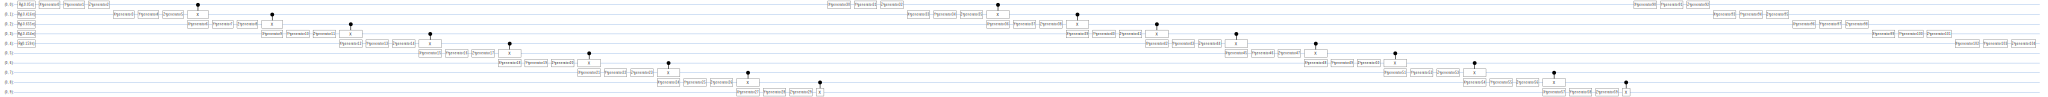

In [ ]:
# params total: (3*features*2)*layer params + (3*features) final params
SVGCircuit(generator(cirq.GridQubit.rect(1, 10), sympy.symbols('generator:105'), layer=2))

The loss function in GANs is a key component of the training process, as it is used to evaluate the performance of the discriminator and generator models. The loss function for the discriminator is typically defined as the negative average of the sum of the logarithms of its predictions for the fake and real data.

Let mfake and mreal denote the total number of fake and real data samples in the batch, respectively. Let D(x) be the discriminator's output for data point x, where D(x) is a real number between 0 and 1. Then the discriminator loss, LD, can be expressed as:

LD = -(1/mfake) * ∑i=1^mfake log(1 - D(xifake)) - (1/mreal) * ∑j=1^mreal log(D(xjreal))


where xifake represents the i-th fake data point and xjreal represents the j-th real data point. The first term in the equation represents the average negative logarithm of the discriminator's output for the fake data, while the second term represents the average logarithm of its output for the real data.

The loss function for the classifier, LC, is typically defined as the categorical cross-entropy loss function. Let ytrue be the true label set of all the samples in the batch, and let C(x) be the class prediction from the classifier. Then LC can be expressed as:

LC = -∑i=1^m ytrue,i * log(C(xi))

where xi is the i-th data point in the batch, and ytrue,i is its corresponding true label. The loss is computed as the sum of the negative logarithms of the predicted probabilities for the true classes.

The final loss function, L, is a weighted sum of the discriminator and classifier losses, where the weight parameter Cweight determines the relative importance of each task. The loss function can be expressed as:

L = (1 - Cweight) * LD + Cweight * LC

When Cweight is high, the classifier is prioritized, while a low Cweight gives priority to the generator's output.

In [ ]:
def discriminator(data_qubits, output_qubits, symbols, layer=1):
    """
    Constructs a Cirq circuit for a discriminator in a quantum machine learning model.

    Args:
        data_qubits (List[cirq.GridQubit]): List of qubits used for encoding input data.
        output_qubits (List[cirq.GridQubit]): List of qubits used for the discriminator's output.
        symbols (np.ndarray): Array of floats used to define the parameters of the unitary operations in the circuit.
        layer (int): Number of layers in the circuit. Default is 1.

    Returns:
        circuit (cirq.Circuit): A Cirq circuit representing the discriminator.
    """
    circuit = cirq.Circuit()

    # Hadamard layer for data qubits
    for i in range(len(data_qubits)):
        circuit += cirq.H(data_qubits[i])
    
    qubits = data_qubits + output_qubits
    for i in range(layer):
        # unitary layer
        for j in range(len(qubits)):
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])

        # entangling layer
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
            else:
                pass

    # final unitary for output qubits
    symbols_last_unitary = symbols[-(3*len(output_qubits)):]
    for i in range(len(output_qubits)):
        circuit += one_qubit_unitary(output_qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    return circuit


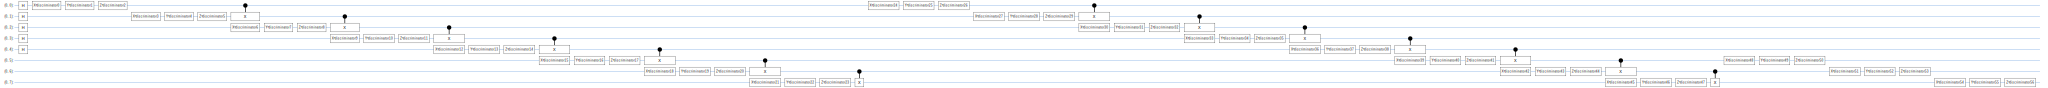

In [ ]:
qubits = cirq.GridQubit.rect(1, 5+3)
# params total: (3 * (features + (num_class + 1)))*layer + 3*(num_class + 1) final params
SVGCircuit(discriminator(qubits[0:5], qubits[5:], sympy.symbols('discriminator:57'), layer=2))

In [ ]:
def create_gen_disc_circuit(symbols_gen, symbols_disc, qubits, num_features, num_class, gen_layer=1, disc_layer=1):
    """
    Constructs a Cirq circuit for a generator-discriminator pair in a quantum machine learning model.

    Args:
        symbols_gen (np.ndarray): Array of floats used to define the parameters of the generator circuit.
        symbols_disc (np.ndarray): Array of floats used to define the parameters of the discriminator circuit.
        qubits (List[cirq.GridQubit]): List of qubits used for the quantum circuit.
        num_features (int): Number of features in the input data.
        num_class (int): Number of classes in the classification task.
        gen_layer (int): Number of layers in the generator circuit. Default is 1.
        disc_layer (int): Number of layers in the discriminator circuit. Default is 1.

    Returns:
        gen_disc_circuit (cirq.Circuit): A Cirq circuit representing the generator-discriminator pair.
    """
    gen_disc_circuit = cirq.Circuit()

    # add the generator
    gen_disc_circuit += generator(qubits[:len(qubits)-(num_class+1)], symbols_gen, layer=gen_layer)
    # add the discriminator
    gen_disc_circuit += discriminator(qubits[:int((len(qubits)-(num_class+1))/2)], qubits[len(qubits)-(num_class+1):], symbols_disc, layer=disc_layer)

    return gen_disc_circuit


In [ ]:
# model fix parameters
num_class = 2
num_features = 5
gen_layer = 6
disc_layer = 6

total_gen_params = (3*num_features*2)*gen_layer + (3*num_features)
total_disc_params = (3*(num_features + num_class + 1))*disc_layer + 3*(num_class + 1)

print(total_gen_params, total_disc_params)

195 153


In [ ]:
def visualize_model_params(total_gen_params, total_disc_params):
    """
    Plots a bar chart showing the number of parameters in the generator and discriminator models.
    
    Args:
    total_gen_params (int): Total number of parameters in the generator model.
    total_disc_params (int): Total number of parameters in the discriminator model.
    
    Returns:
    None
    """
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the number of parameters in the generator model
    axs[0].bar(['Generator'], [total_gen_params])
    axs[0].set_title("Total Generator Parameters")
    axs[0].set_ylabel("Number of Parameters")
    
    # Plot the number of parameters in the discriminator model
    axs[1].bar(['Discriminator'], [total_disc_params])
    axs[1].set_title("Total Discriminator Parameters")
    axs[1].set_ylabel("Number of Parameters")
    
    # Display the bar chart
    plt.show()


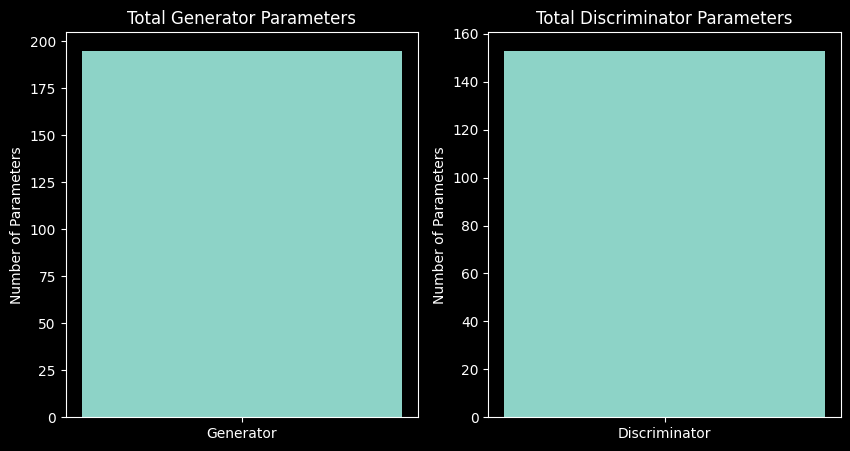

In [ ]:
visualize_model_params(total_gen_params, total_disc_params)

In [ ]:
# trainable parameters
symbols_gen = sympy.symbols('gen0:' + str(total_gen_params))
symbols_disc = sympy.symbols('disc0:' + str(total_disc_params))

# qubits
qgan_qubits = cirq.GridQubit.rect(1, num_features*2 + num_class + 1)

The discriminator loss function is used to train the discriminator network in a Generative Adversarial Network (GAN). The discriminator network tries to distinguish between real and fake data, and the loss function is used to update the network's parameters to improve its performance.

The discriminator loss function consists of two parts: the first part calculates the loss based on the discriminator's ability to correctly classify real and fake data (D_loss), while the second part calculates the loss based on the discriminator's ability to correctly classify the class label of the data (C_loss).

The code uses the sigmoid activation function to transform the discriminator's output to a value between 0 and 1, which is interpreted as the probability that the input is real. The loss is calculated using binary cross-entropy loss for D_loss and categorical cross-entropy loss for C_loss.

The C_weight variable is used to control the weight of the C_loss term in the overall loss function. The discriminator loss function is defined as a TensorFlow function to take advantage of the performance benefits of TensorFlow's computation graph.

In [ ]:
C_weight = 0.5

@tf.function
def disc_loss(y_true, y_pred):
    """
    This function defines the loss function for the discriminator network in a conditional GAN.
    The loss function is a combination of the binary cross-entropy loss for the discriminator output
    and the categorical cross-entropy loss for the classifier output.

    Args:
    y_true: A tensor of shape (batch_size, 3), representing the true labels.
    The first two columns correspond to the true class labels (one-hot encoded) and
    the third column corresponds to the discriminator's true/fake label (1 for true, -1 for fake).
    y_pred: A tensor of shape (batch_size, 3), representing the predicted labels.
    The first two columns correspond to the predicted class labels (one-hot encoded) and
    the third column corresponds to the discriminator's predicted true/fake label.

    Returns:
    A tensor representing the loss for the discriminator network.

    """
    # Binary cross-entropy loss for the discriminator output
    D_true = (y_true[:, 2] + 1)/2
    D_pred = (y_pred[:, 2] + 1)/2

    D_loss = -1*(tf.math.log(D_pred + 1e-10)*D_true + tf.math.log(1 - D_pred + 1e-10)*(D_true - 1)*(-1))
    D_loss = tf.reduce_mean(D_loss, axis=0)

    # Categorical cross-entropy loss for the classifier output
    C_true = (y_true[:, :2] + 1)/2
    C_pred = (y_pred[:, :2] + 1)/2

    # Weight the loss for real samples
    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10
    C_loss = tf.math.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true, C_pred) * D_true)/D_true_size

    return (1-C_weight)*D_loss + C_weight*C_loss

In [ ]:
@tf.function
def custom_accuracy(y_true, y_pred):
    """
    Computes the custom accuracy metric for the model.
    
    The metric takes into account the class weights and the discriminator's predictions.

    Parameters:
    y_true (tensor): A tensor of true labels.
    y_pred (tensor): A tensor of predicted labels.

    Returns:
    Tensor: A scalar tensor representing the custom accuracy metric.

    """
    # Compute the weights for each sample based on their true label.
    D_true = (y_true[:, 2] + 1) / 2

    # Extract the real class labels from the tensors.
    C_real_true = (y_true[:, :2] + 1) / 2
    C_real_pred = (y_pred[:, :2] + 1) / 2

    # Compute the predicted class labels.
    C_real_true = tf.math.argmax(C_real_true, axis=1)
    C_real_pred = tf.math.argmax(C_real_pred, axis=1)

    # Compute the accuracy only for the samples with a true label of 1 (class 1).
    same = tf.cast(C_real_true == C_real_pred, tf.float32) * D_true

    # Compute the size of the true class 1 samples.
    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10

    # Compute and return the custom accuracy metric.
    return tf.math.reduce_sum(same) / D_true_size
     

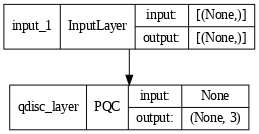

In [ ]:
# discriminator model

def discriminator_model(discriminator_weights):
    """
    Defines the discriminator model and compiles it with the Adam optimizer and the custom loss and accuracy functions.
    Args:
    discriminator_weights: trainable initial values of the symbols in the quantum gates of the discriminator model.

    Returns:
    qdisc_model: compiled discriminator model
    """
    # Define the operators for the qubits in the discriminator readout layer
    disc_readout_operators = [cirq.Z(qgan_qubits[-(num_class+1) + q]) for q in range(num_class+1)]

    # Define data input
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    # Define the quantum layer for the discriminator
    qdisc_layer = tfq.layers.PQC(discriminator(qgan_qubits[:int((len(qgan_qubits)-(num_class+1))/2)],
                  qgan_qubits[len(qgan_qubits)-(num_class+1):], discriminator_weights, layer=disc_layer),
                  disc_readout_operators, name='qdisc_layer')(data_input)

    # Define and compile the discriminator model
    qdisc_model = tf.keras.Model(inputs=[data_input], outputs=[qdisc_layer])
    qdisc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss=disc_loss,
                        metrics=[custom_accuracy])

    return qdisc_model


qdisc_model = discriminator_model(symbols_disc)

# Show the keras plot of the model
tf.keras.utils.plot_model(qdisc_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)


In [ ]:
def gen_loss(y_true, y_pred):
    """
    Calculates the generator loss.
    Arguments:
    y_true -- tensor of true labels
    y_pred -- tensor of predicted labels

    Returns:
    Generator loss as a tensor.
    """
    D_fake = (y_pred[:, 2] + 1)/2
    G_loss = tf.reduce_mean((-1)*tf.math.log(D_fake), axis=0)
    return G_loss

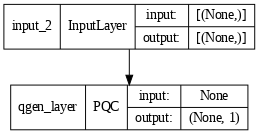

In [ ]:
def generator_model(generator_symbols, discriminator_weights):
    """
    Creates and compiles a quantum generator model with a given set of generator symbols and discriminator weights.

    Args:
        generator_symbols (List[cirq.Symbol]): A list of cirq.Symbol objects representing the generator parameters.
        discriminator_weights (numpy.ndarray): An array of weights representing the trained discriminator model.

    Returns:
        A compiled quantum generator model.
    """
    # Define readout operators for the generator
    generator_readout_operators = cirq.Z(qgan_qubits[-1])

    # Define input layer for the model
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    # Define the PQC layer for the generator
    generator_layer = tfq.layers.PQC(
        create_gen_disc_circuit(
            generator_symbols, discriminator_weights,
            qgan_qubits, num_features, num_class,
            generator_layer=generator_layer, discriminator_layer=discriminator_layer
        ),
        generator_readout_operators,
        name='generator_layer'
    )(data_input)

    # Define the generator model with the input layer and PQC layer
    generator_model = tf.keras.Model(inputs=[data_input], outputs=[generator_layer])

    # Compile the generator model with Adam optimizer and generator loss
    generator_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=generator_loss
    )

    return generator_model

# Create the generator model with the generator symbols and the weights from the discriminator model
generator_model = create_generator_model(generator_symbols, discriminator_model.get_weights()[0])

# Plot the model using Keras' plot_model utility
tf.keras.utils.plot_model(
    generator_model,
    show_shapes=True,
    show_layer_names=True,
    dpi=70
)


In [ ]:
def generate_identity_data(data_samples):
    """
    Generates identity quantum data for a given number of samples.

    Args:
        data_samples (int): The number of data samples to generate.

    Returns:
        A list of cirq.Circuit objects representing the identity quantum data.
    """
    identity_data = []
    # iterate through data samples
    for sample_index in range(data_samples):
        circuit = cirq.Circuit()
        
        identity_data.append(circuit)

    return identity_data


In [ ]:
identity_data = tfq.convert_to_tensor(generate_identity(x_train))
identity_label = np.zeros((len(identity_data),))

# Sanity check
print(len(identity_data), identity_label.shape)

100 (100,)


In [ ]:
# Plot the distribution of the identity data
def plot_identity_data_distribution(identity_data):
    """
    Plots the distribution of identity quantum data.

    Args:
        identity_data (list): A list of cirq.Circuit objects representing the identity quantum data.
    """
    # Set the font to Arial
    plt.rcParams['font.family'] = 'Arial'
    
    # Create a histogram of the identity data values
    flattened_identity_data = np.array([identity_data_sample for identity_data_sample in identity_data]).flatten()
    fig, axs = plt.subplots(figsize=(7, 5))
    axs.hist(flattened_identity_data, bins=50)
    
    # Set the plot title, x-axis label, and y-axis label
    axs.set_title("Identity Data Distribution")
    axs.set_xlabel("Value")
    axs.set_ylabel("Count")
    
    # Show the plot
    plt.show()


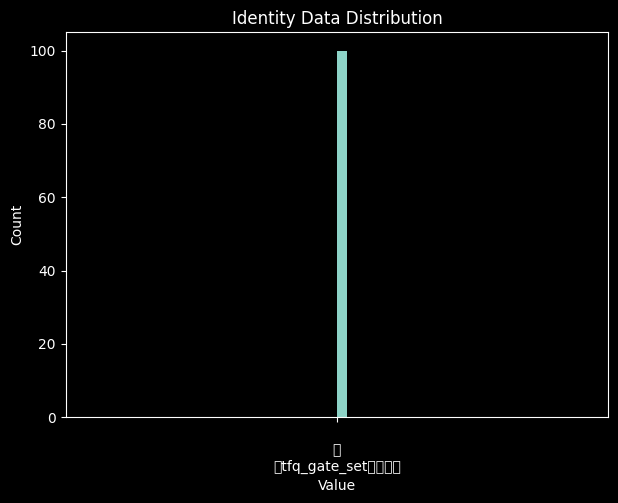

In [ ]:
# Plotting the distribution of the identity data
plot_identity_data_distribution(identity_data)

In [ ]:
def generate_fake_data(real_data_samples, qubits, generator_symbols, generator_layer=1):
    """
    Generates fake quantum data using a quantum generator circuit.

    Args:
        real_data_samples (int): The number of real data samples used to determine how many fake samples to generate.
        qubits (list): A list of cirq.GridQubit objects representing the qubits to use in the generator circuit.
        generator_symbols (list): A list of cirq.Symbol objects representing the symbols to use in the generator circuit.
        generator_layer (int): The number of layers to use in the generator circuit.

    Returns:
        A list of cirq.Circuit objects representing the fake quantum data.
    """
    fake_data = []
    # iterate through the number of fake samples to generate
    for _ in range(real_data_samples):
        generator_circuit = generator(qubits[:2 * len(generator_symbols)], generator_symbols, layer=generator_layer)
        
        fake_data.append(generator_circuit)

    return fake_data


In [ ]:
fake_data = tfq.convert_to_tensor(generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
y_true_fake = np.zeros((len(fake_data), num_class+1))
y_true_fake[:, 2] += (-1)

y_true_fake.shape

(100, 3)

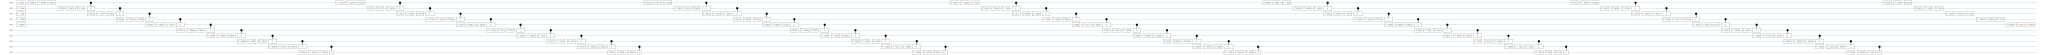

In [ ]:
SVGCircuit(tfq.from_tensor(fake_data)[0])

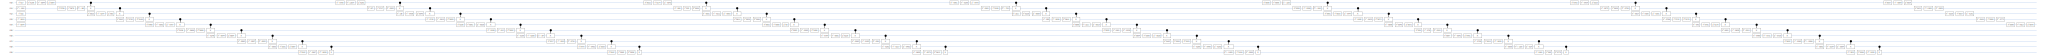

In [ ]:
SVGCircuit(tfq.from_tensor(fake_data)[1])

In [ ]:
# Model initialization
qdisc_model = discriminator_model(symbols_disc)
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

In [ ]:
def checkpoints(cycle):
    gen_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='cp_generator_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)

    disc_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='cp_disc_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='custom_accuracy',
        mode='max',
        save_best_only=True)
    
    return gen_model_cp, disc_model_cp
     

In [ ]:
def train_qgen(epochs, batch, verbose):
    # Fit the Generator Model
    history = qgen_model.fit(x=identity_data,
                            y=identity_label,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[gen_model_cp])
    
    return history

In [ ]:
def train_qdisc(epochs, batch, verbose):
    # Fit the Discriminator Model
    history = qdisc_model.fit(x=gen_data_train,
                            y=y_gen_train,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[disc_model_cp],
                            validation_data=(gen_data_test, y_gen_test)
                            )
    return history

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# re-declare the generator model using the discriminator's weights
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])
     

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=1)

In [ ]:
# Fit the Generator Model
H = train_qgen(2000, 100, 1)

Epoch 1/2000
1/1 [==============================] - 4s 4s/step - loss: 0.6485
Epoch 2/2000
1/1 [==============================] - 3s 3s/step - loss: 0.6432
Epoch 3/2000
1/1 [==============================] - 3s 3s/step - loss: 0.6380
Epoch 4/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6328
Epoch 5/2000
1/1 [==============================] - 5s 5s/step - loss: 0.6276
Epoch 6/2000
1/1 [==============================] - 3s 3s/step - loss: 0.6225
Epoch 7/2000
1/1 [==============================] - 7s 7s/step - loss: 0.6174
Epoch 8/2000
1/1 [==============================] - 9s 9s/step - loss: 0.6124
Epoch 9/2000
1/1 [==============================] - 6s 6s/step - loss: 0.6074
Epoch 10/2000
1/1 [==============================] - 7s 7s/step - loss: 0.6025
Epoch 11/2000
1/1 [==============================] - 8s 8s/step - loss: 0.5977
Epoch 12/2000
1/1 [==============================] - 6s 6s/step - loss: 0.5929
Epoch 13/2000
1/1 [==============================] - 3s 3s/st

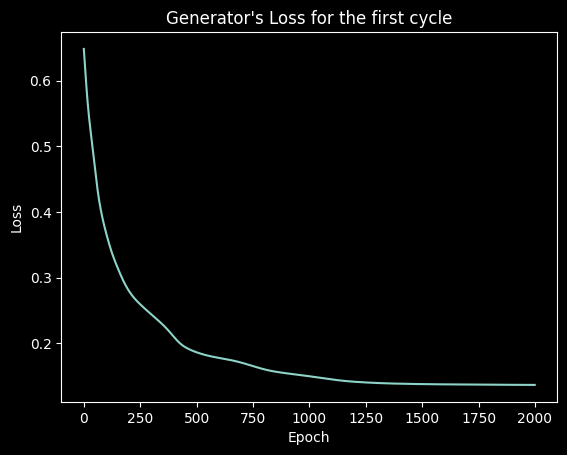

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss for the first cycle")
plt.show()

In [ ]:
# Generate Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(len(gen_data_train), len(gen_data_test))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


In [ ]:
# Fit the Discriminator Model
H = train_qdisc(300, 64, 1)

Epoch 1/300
4/4 [==============================] - 8s 2s/step - loss: 0.6946 - custom_accuracy: 0.4586 - val_loss: 0.5666 - val_custom_accuracy: 0.2830
Epoch 2/300
4/4 [==============================] - 8s 2s/step - loss: 0.6869 - custom_accuracy: 0.5144 - val_loss: 0.5626 - val_custom_accuracy: 0.2830
Epoch 3/300
4/4 [==============================] - 8s 2s/step - loss: 0.6799 - custom_accuracy: 0.6092 - val_loss: 0.5588 - val_custom_accuracy: 0.2830
Epoch 4/300
4/4 [==============================] - 6s 2s/step - loss: 0.6749 - custom_accuracy: 0.6767 - val_loss: 0.5552 - val_custom_accuracy: 0.2899
Epoch 5/300
4/4 [==============================] - 10s 2s/step - loss: 0.6699 - custom_accuracy: 0.5763 - val_loss: 0.5520 - val_custom_accuracy: 0.2899
Epoch 6/300
4/4 [==============================] - 6s 2s/step - loss: 0.6653 - custom_accuracy: 0.5019 - val_loss: 0.5490 - val_custom_accuracy: 0.2899
Epoch 7/300
4/4 [==============================] - 8s 2s/step - loss: 0.6598 - custom_a

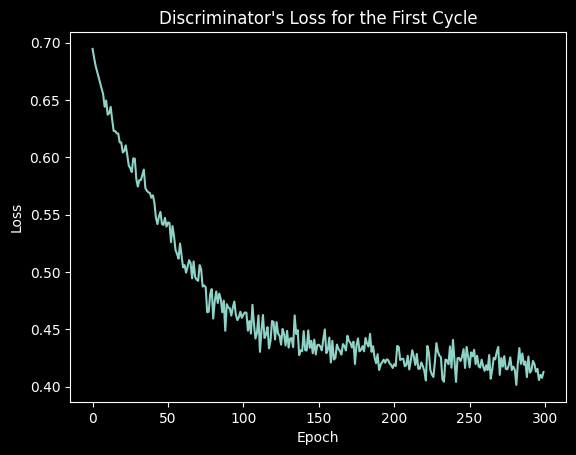

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss for the First Cycle")
plt.show()

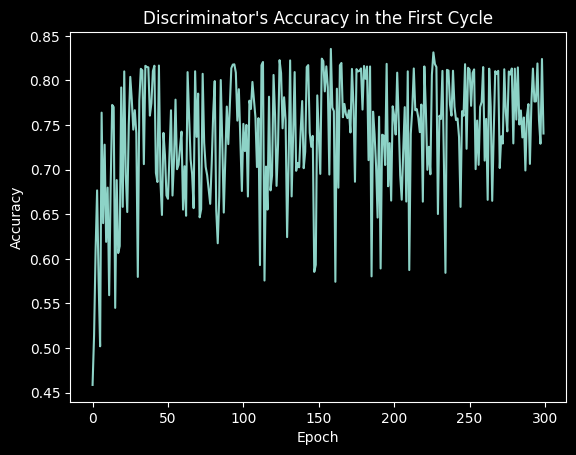

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy in the First Cycle")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=2)

In [ ]:
# Fit the Generator Model
H = train_qgen(500, 100, 1)

Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 0.7027
Epoch 2/500
1/1 [==============================] - 4s 4s/step - loss: 0.6953
Epoch 3/500
1/1 [==============================] - 3s 3s/step - loss: 0.6879
Epoch 4/500
1/1 [==============================] - 3s 3s/step - loss: 0.6806
Epoch 5/500
1/1 [==============================] - 5s 5s/step - loss: 0.6733
Epoch 6/500
1/1 [==============================] - 5s 5s/step - loss: 0.6660
Epoch 7/500
1/1 [==============================] - 3s 3s/step - loss: 0.6588
Epoch 8/500
1/1 [==============================] - 3s 3s/step - loss: 0.6516
Epoch 9/500
1/1 [==============================] - 3s 3s/step - loss: 0.6444
Epoch 10/500
1/1 [==============================] - 6s 6s/step - loss: 0.6373
Epoch 11/500
1/1 [==============================] - 4s 4s/step - loss: 0.6303
Epoch 12/500
1/1 [==============================] - 3s 3s/step - loss: 0.6233
Epoch 13/500
1/1 [==============================] - 3s 3s/step - loss: 0.

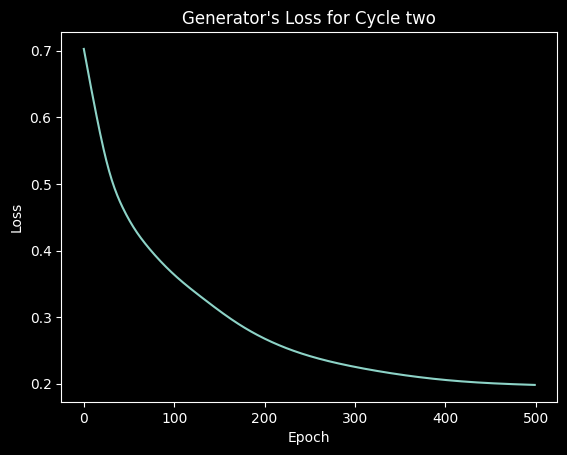

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss for Cycle two")
plt.show()

In [ ]:
# Generate Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(len(gen_data_train), len(gen_data_test))
print(y_gen_train.shape, y_gen_test.shape)

200 200
(200, 3) (200, 3)


In [ ]:
# Fit the Discriminator Model
H = train_qdisc(300, 64, 1)

Epoch 1/300
4/4 [==============================] - 9s 2s/step - loss: 0.4629 - custom_accuracy: 0.7569 - val_loss: 0.4142 - val_custom_accuracy: 0.3442
Epoch 2/300
4/4 [==============================] - 6s 2s/step - loss: 0.4602 - custom_accuracy: 0.7605 - val_loss: 0.4123 - val_custom_accuracy: 0.3442
Epoch 3/300
4/4 [==============================] - 9s 3s/step - loss: 0.4646 - custom_accuracy: 0.6966 - val_loss: 0.4078 - val_custom_accuracy: 0.3442
Epoch 4/300
4/4 [==============================] - 6s 2s/step - loss: 0.4624 - custom_accuracy: 0.7419 - val_loss: 0.4014 - val_custom_accuracy: 0.3511
Epoch 5/300
4/4 [==============================] - 7s 2s/step - loss: 0.4498 - custom_accuracy: 0.7694 - val_loss: 0.3970 - val_custom_accuracy: 0.3511
Epoch 6/300
4/4 [==============================] - 9s 2s/step - loss: 0.4459 - custom_accuracy: 0.8149 - val_loss: 0.3934 - val_custom_accuracy: 0.3542
Epoch 7/300
4/4 [==============================] - 6s 2s/step - loss: 0.4398 - custom_ac

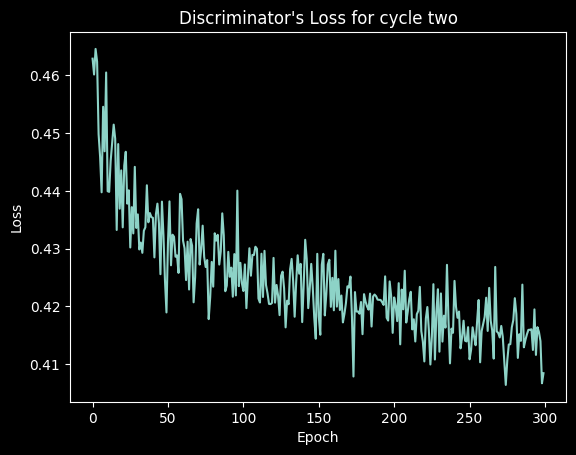

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss for cycle two")
plt.show()

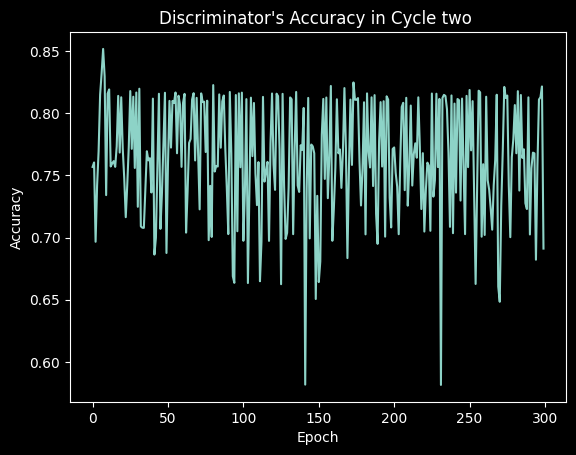

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy in Cycle two ")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

In [ ]:
# 3rd Cycle
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=3)

In [ ]:
# Generator training
H = train_qgen(300, 100, 1)

Epoch 1/300
1/1 [==============================] - 6s 6s/step - loss: 0.6963
Epoch 2/300
1/1 [==============================] - 4s 4s/step - loss: 0.6847
Epoch 3/300
1/1 [==============================] - 3s 3s/step - loss: 0.6733
Epoch 4/300
1/1 [==============================] - 3s 3s/step - loss: 0.6620
Epoch 5/300
1/1 [==============================] - 4s 4s/step - loss: 0.6510
Epoch 6/300
1/1 [==============================] - 6s 6s/step - loss: 0.6402
Epoch 7/300
1/1 [==============================] - 4s 4s/step - loss: 0.6297
Epoch 8/300
1/1 [==============================] - 3s 3s/step - loss: 0.6194
Epoch 9/300
1/1 [==============================] - 3s 3s/step - loss: 0.6093
Epoch 10/300
1/1 [==============================] - 5s 5s/step - loss: 0.5995
Epoch 11/300
1/1 [==============================] - 5s 5s/step - loss: 0.5900
Epoch 12/300
1/1 [==============================] - 3s 3s/step - loss: 0.5807
Epoch 13/300
1/1 [==============================] - 3s 3s/step - loss: 0.

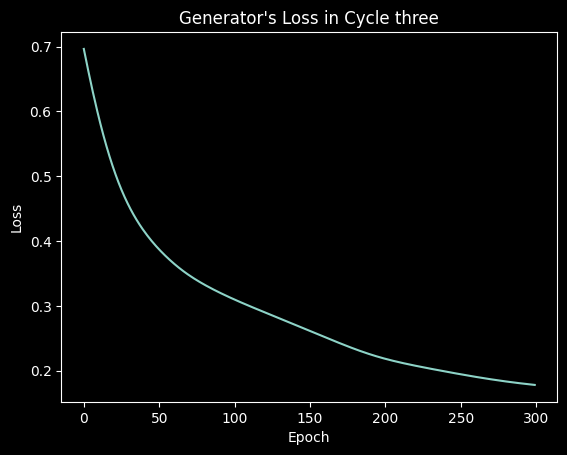

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss in Cycle three")
plt.show()

In [ ]:
gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


In [ ]:
# Change the C_weight
C_weight = 0.70

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(400, 64, 1)

Epoch 1/400
4/4 [==============================] - 8s 2s/step - loss: 0.4484 - custom_accuracy: 0.6611 - val_loss: 0.4062 - val_custom_accuracy: 0.3442
Epoch 2/400
4/4 [==============================] - 6s 2s/step - loss: 0.4440 - custom_accuracy: 0.7589 - val_loss: 0.4061 - val_custom_accuracy: 0.3442
Epoch 3/400
4/4 [==============================] - 10s 2s/step - loss: 0.4502 - custom_accuracy: 0.6977 - val_loss: 0.4066 - val_custom_accuracy: 0.3442
Epoch 4/400
4/4 [==============================] - 6s 2s/step - loss: 0.4436 - custom_accuracy: 0.7235 - val_loss: 0.4065 - val_custom_accuracy: 0.3442
Epoch 5/400
4/4 [==============================] - 8s 2s/step - loss: 0.4428 - custom_accuracy: 0.8142 - val_loss: 0.4062 - val_custom_accuracy: 0.3442
Epoch 6/400
4/4 [==============================] - 8s 2s/step - loss: 0.4428 - custom_accuracy: 0.8129 - val_loss: 0.4060 - val_custom_accuracy: 0.3442
Epoch 7/400
4/4 [==============================] - 6s 2s/step - loss: 0.4486 - custom_a

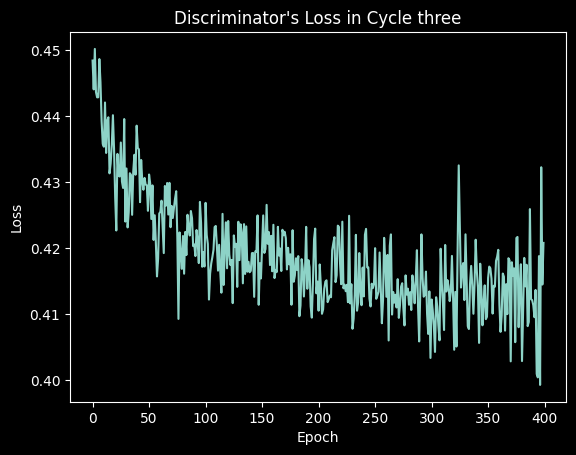

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss in Cycle three")
plt.show()

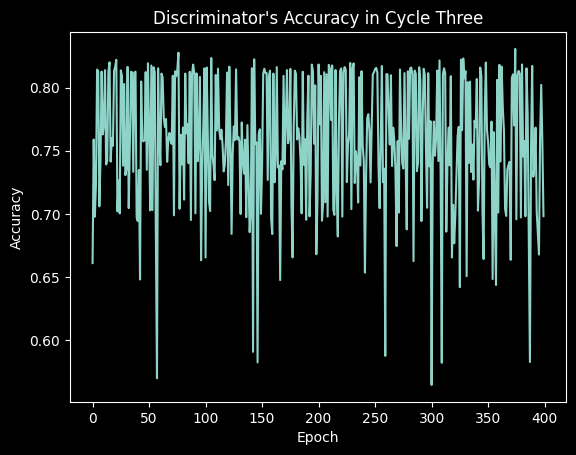

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy in Cycle Three")
plt.show()

In [ ]:
# Forth cycle
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=4)

In [ ]:
# Fit the Generator Model
H = train_qgen(200, 100, 1)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.5887
Epoch 2/200
1/1 [==============================] - 4s 4s/step - loss: 0.5801
Epoch 3/200
1/1 [==============================] - 6s 6s/step - loss: 0.5718
Epoch 4/200
1/1 [==============================] - 4s 4s/step - loss: 0.5637
Epoch 5/200
1/1 [==============================] - 3s 3s/step - loss: 0.5558
Epoch 6/200
1/1 [==============================] - 3s 3s/step - loss: 0.5481
Epoch 7/200
1/1 [==============================] - 5s 5s/step - loss: 0.5406
Epoch 8/200
1/1 [==============================] - 6s 6s/step - loss: 0.5333
Epoch 9/200
1/1 [==============================] - 3s 3s/step - loss: 0.5262
Epoch 10/200
1/1 [==============================] - 3s 3s/step - loss: 0.5193
Epoch 11/200
1/1 [==============================] - 3s 3s/step - loss: 0.5125
Epoch 12/200
1/1 [==============================] - 5s 5s/step - loss: 0.5059
Epoch 13/200
1/1 [==============================] - 5s 5s/step - loss: 0.

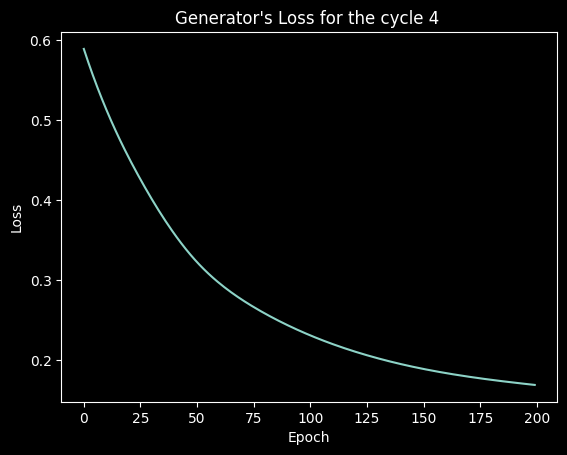

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss for the cycle 4 ")
plt.show()

In [ ]:
# Combine Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


For cycle 4 weight $C_{weight}$ is increased from $0.70  → 0.95$

In [ ]:
# Change the C_weight
C_weight = 0.95

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(300, 64, 1)

Epoch 1/300
4/4 [==============================] - 6s 2s/step - loss: 0.4453 - custom_accuracy: 0.6757 - val_loss: 0.3755 - val_custom_accuracy: 0.3472
Epoch 2/300
4/4 [==============================] - 8s 2s/step - loss: 0.4473 - custom_accuracy: 0.8131 - val_loss: 0.3755 - val_custom_accuracy: 0.3472
Epoch 3/300
4/4 [==============================] - 8s 2s/step - loss: 0.4511 - custom_accuracy: 0.8088 - val_loss: 0.3760 - val_custom_accuracy: 0.3472
Epoch 4/300
4/4 [==============================] - 6s 2s/step - loss: 0.4296 - custom_accuracy: 0.7785 - val_loss: 0.3765 - val_custom_accuracy: 0.3472
Epoch 5/300
4/4 [==============================] - 10s 3s/step - loss: 0.4363 - custom_accuracy: 0.7663 - val_loss: 0.3772 - val_custom_accuracy: 0.3472
Epoch 6/300
4/4 [==============================] - 6s 2s/step - loss: 0.4386 - custom_accuracy: 0.7443 - val_loss: 0.3773 - val_custom_accuracy: 0.3472
Epoch 7/300
4/4 [==============================] - 8s 2s/step - loss: 0.4381 - custom_a

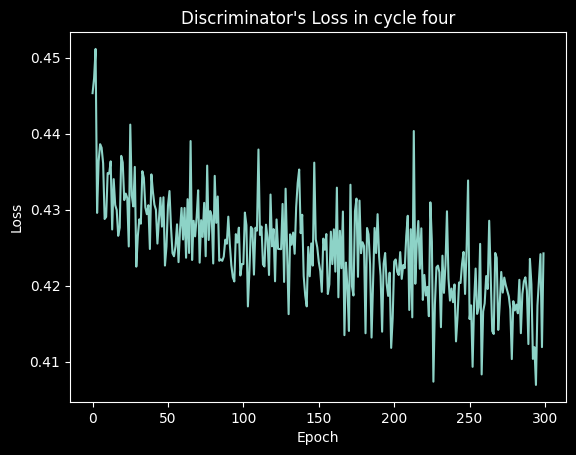

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss in cycle four")
plt.show()

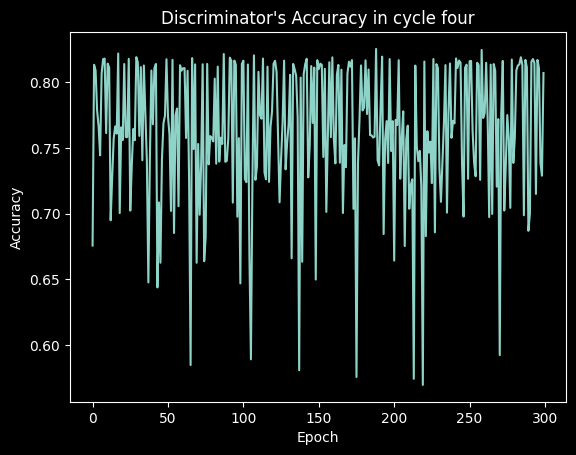

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy in cycle four")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

In the fifth cycle of training, the focus is on achieving the best possible classification performance. This is reflected in the loss function, where the weight assigned to the classification loss is the highest. As a result, the contribution of the detection loss becomes negligible.

Therefore, in this cycle, the primary objective is to train the discriminator to become a highly effective classifier by optimizing the classification loss.

$$
L = (1-C_{weight})L_{D} + C_{weight}L_{C}
$$


In [ ]:
# fit the model
history = qdisc_model.fit(x=train_quantum_data,
                          y=y_train,
                          batch_size=32,
                          epochs=1000,
                          verbose=1,
                          callbacks=[disc_model_cp],
                          validation_data=(test_quantum_data, y_test)
                          )

Epoch 1/1000
4/4 [==============================] - 2s 570ms/step - loss: 0.3143 - custom_accuracy: 0.8125 - val_loss: 0.3468 - val_custom_accuracy: 0.7734
Epoch 2/1000
4/4 [==============================] - 2s 513ms/step - loss: 0.3126 - custom_accuracy: 0.7578 - val_loss: 0.3452 - val_custom_accuracy: 0.7734
Epoch 3/1000
4/4 [==============================] - 1s 389ms/step - loss: 0.3109 - custom_accuracy: 0.8125 - val_loss: 0.3434 - val_custom_accuracy: 0.7734
Epoch 4/1000
4/4 [==============================] - 1s 328ms/step - loss: 0.3095 - custom_accuracy: 0.7578 - val_loss: 0.3426 - val_custom_accuracy: 0.7734
Epoch 5/1000
4/4 [==============================] - 1s 326ms/step - loss: 0.3087 - custom_accuracy: 0.7031 - val_loss: 0.3413 - val_custom_accuracy: 0.7734
Epoch 6/1000
4/4 [==============================] - 1s 329ms/step - loss: 0.3072 - custom_accuracy: 0.7578 - val_loss: 0.3408 - val_custom_accuracy: 0.7734
Epoch 7/1000
4/4 [==============================] - 1s 325ms/ste

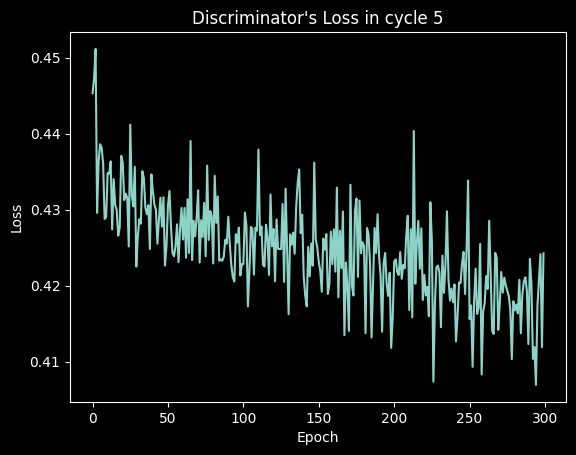

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss in cycle 5")
plt.show()

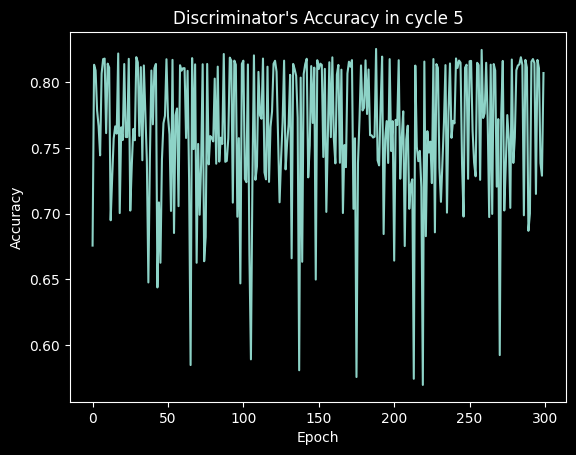

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy in cycle 5")
plt.show()

In [ ]:
qdisc_model.save_weights('disc_final.h5')
qgen_model.save_weights('gen_final.h5')

In [ ]:
qdisc_model.load_weights('disc_final.h5')

In [ ]:
from sklearn.metrics import roc_auc_score

print("Training Accuracy:", custom_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("Testing Accuracy", custom_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("Training AUC:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("Testing AUC:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))

Training Accuracy: 0.78
Testing Accuracy 0.71
Training AUC: 0.8132
Testing AUC: 0.6784
